# Imports

In [1]:
import pickle
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
import json
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Plotting functions

In [2]:
def print_loss(dataloader, title):
    losses = []
    with torch.no_grad():
        for x in dataloader:
            n_batch = x.shape[0]
            x = x.to(device=device, dtype=torch.float)
            rec, emb = ae(x)
            l = loss(x, rec)
            losses.append(l.detach().cpu().item())
    print(title, np.sum(losses) / len(dataloader))

    
def create_hists(hist_orig, edges_orig, hist_rec, edges_rec, title):
    p = figure(title=title, tools = 'pan, wheel_zoom, box_zoom, reset, save')
    p.quad(top=hist_orig, bottom=0, left=edges_orig[:-1], right=edges_orig[1:],
           fill_color='orange', line_color='orange', alpha=0.25, legend_label='original')
    p.quad(top=hist_rec, bottom=0, left=edges_rec[:-1], right=edges_rec[1:],
           fill_color='blue', line_color='blue', alpha=0.25, legend_label='reconstructed')

    p.xaxis.axis_label = 'value'
    p.yaxis.axis_label = 'count'
    p.plot_width = 450
    p.plot_height = 450
    p.legend.click_policy = 'hide'
    
    return p


def create_hist_plots(df_orig, df_rec, bins=100):
    plots = []
    for colname in df_orig.columns:
        data_orig, data_rec = df_orig[colname].values, df_rec[colname].values
        hist_orig, edges_orig = np.histogram(data_orig, density=False, bins=bins)
        hist_rec, edges_rec = np.histogram(data_rec, density=False, bins=bins)
        plots.append(create_hists(hist_orig, edges_orig, hist_rec, edges_rec, title=colname))
        
    return show(gridplot(plots, ncols=2))


def create_scatterplot(orig, rec, title):
    p = figure(title=title, tools = 'pan, wheel_zoom, box_zoom, reset, save')
    p.scatter(orig, rec, color='grey', alpha=0.5)
    p.line(x=[np.min(orig), np.max(orig)], y=[np.min(orig), np.max(orig)], color='red', line_width=2)
    
    p.xaxis.axis_label = 'Original'
    p.yaxis.axis_label = 'Reconstructed'
    p.plot_width = 450
    p.plot_height = 450
    
    return p


def create_scatterplots(orig, recs):
    plots = []
    for colname in orig.columns:
        data_orig, data_rec = orig[colname].values, recs[colname].values
        plots.append(create_scatterplot(data_orig, data_rec, title=colname))
        
    return show(gridplot(plots, ncols=2))


def create_plot(data, hist, edges, title):
    p = figure(title=title, tools = 'pan, wheel_zoom, box_zoom, reset, save')
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color='black', line_color='black', alpha=0.5)
    height = np.max(hist)
    mean, std = np.mean(data), np.std(data)
    p.line(x=[mean - 1.96 * std] * 2, y=[0, height], line_color='red', line_dash='dashed',
           legend_label='+- 1.96 std')
    p.line(x=[mean] * 2, y=[0, height], line_color='red', legend_label='mean')
    p.line(x=[mean + 1.96 * std] * 2, y=[0, height], line_color='red', line_dash='dashed')

    p.xaxis.axis_label = '(orig - rec) / orig'
    p.yaxis.axis_label = 'Counts'
    p.plot_width = 450
    p.plot_height = 450
    
    return p


def create_plots(df, bins=100):
    plots = []
    for colname in df.columns:
        data = df[colname].values
        hist, edges = np.histogram(data, density=False, bins=bins)
        plots.append(create_plot(data, hist, edges, title=colname))
        
    return show(gridplot(plots, ncols=2))

# Dataset

In [3]:
class PickleDataset(Dataset):
    
    def __init__(self, fpath, normalize: str = 'z-score'):
        with open(fpath, 'rb') as fin:
            data = pickle.load(fin)
            self.orig = data
        if normalize == 'z-score':
            mean, sd = data.mean(0).values[np.newaxis, :], data.std(0).values[np.newaxis, :]
            data = (data - mean) / sd
        elif normalize == 'log+1':
            data['m'] = np.log1p(data['m'])
            data['pt'] = np.log1p(data['pt'])
            data['phi'] = data['phi'] / 3
            data['eta'] = data['eta'] / 3
        
        self._data = data.values
    
    def __len__(self):
        return self._data.shape[0]
    
    def __getitem__(self, idx):
        return self._data[idx]

In [4]:
trn_d = PickleDataset('all_jets_train_4D_100_percent.pkl', normalize='log+1')
tst_d = PickleDataset('all_jets_test_4D_100_percent.pkl', normalize='log+1')

In [5]:
bs = 128
n_epochs = 10_000
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
trn_loader, tst_loader = DataLoader(trn_d, batch_size=bs, shuffle=True, drop_last=True), \
    DataLoader(tst_d, batch_size=len(tst_d), shuffle=False, drop_last=False)

# Autoencoder

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 4),
        )
    
    def forward(self, x):
        emb = self.encoder(x)
        return self.decoder(emb), emb
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [8]:
ae = Network().apply(init_weights).to(device)
loss = nn.MSELoss()

In [9]:
ae.load_state_dict(torch.load('ae_10000.pth'))

<All keys matched successfully>

In [10]:
optAE = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optAE, 1e-3, epochs=10_000, steps_per_epoch=int(len(trn_d) / bs))

# Training

In [11]:
if False:
    step = 0
    tl = []
    writer = SummaryWriter('ae')
    for i in range(n_epochs):
        ae = ae.train()
        losses = []
        for x in trn_loader:
            n_batch = x.shape[0]
            optAE.zero_grad()
            x = x.to(device=device, dtype=torch.float)
            rec, emb = ae(x)
            l = loss(x, rec)
            l.backward()
            optAE.step()

            if step % 100 == 0:
                writer.add_scalar('rec_loss', l.detach().cpu().numpy(), step)

            step += 1

        ae = ae.eval()
        with torch.no_grad():
            for x in tst_loader:
                n_batch = x.shape[0]
                x = x.to(device=device, dtype=torch.float)
                rec, emb = ae(x)
                l = loss(x, rec)
                losses.append(l.detach().cpu().item())
        tl.append(np.mean(tl))
        print('Epoch:', i, np.mean(losses))
        scheduler.step(i)

In [12]:
torch.save(ae.state_dict(), 'ae_10000.pth')

Because I forgot now I have to do this...

# Evaluation

Text(0, 0.5, 'Value')

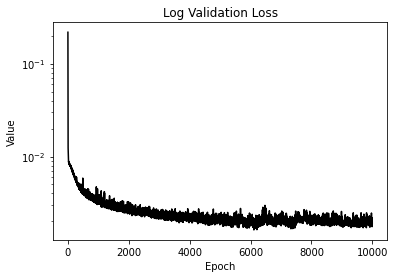

In [13]:
#with open('ae.ipynb', 'r') as fin:
#    data = json.load(fin)

# losses = [float(l.split()[-1].strip()) for d in data['cells'][14]['outputs'][1:] for l in d['text']]
# with open('losses.pickle', 'wb') as fout:
    # pickle.dump(losses, fout)
    
with open('losses.pickle', 'rb') as fin:
    losses = pickle.load(fin)
fig, ax = plt.subplots()
ax.plot(losses, color='black')
ax.set_yscale('log')
ax.set_title('Log Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

In [14]:
print_loss(trn_loader, 'Training loss')
print_loss(tst_loader, 'Testing loss')

Training loss 0.0018985038171154271
Testing loss 0.0019190094899386168


In [15]:
results = []
orig = []
recs = []
eps = 1e-12
with torch.no_grad():
    for x in tst_loader:
        rec, _ = ae(x.to(device=device, dtype=torch.float))
        x = x.numpy()
        x[x == 0] = eps
        rec = rec.cpu().numpy()
        results.extend((x - rec) / x)
        orig.extend(x)
        recs.extend(rec)

In [16]:
colnames = ['log m', 'log pt', 'phi / 3', 'eta / 3']
results = pd.DataFrame(np.array(results), columns=colnames)
orig = pd.DataFrame(np.array(orig), columns=colnames)
recs = pd.DataFrame(np.array(recs), columns=colnames)

results.head()

,log m,log pt,phi / 3,eta / 3
0,0.000195,-0.000935,0.006020,3.170019
1,-0.001322,-0.000258,-0.002798,-0.044492
2,0.032753,-0.026515,-0.003631,0.004986
3,0.003332,-0.003402,-0.031968,0.097629
4,-0.001064,0.000162,-0.031085,0.149918


# Plotting

In [17]:
create_hist_plots(orig, recs, bins=50)

In [18]:
create_scatterplots(orig, recs)

In [19]:
create_plots(results, bins=100)